### Scenario- You are a junior data scientist on the Zillow data science team and are tasked with the following:

- Predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017
- Make recommendations to improve the current model
- Find the states and counties in which these properties are located

### Business goals:

- Create an ML Regression model that will predict property values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties
- Find the key drivers of property value for Single Family Properties. 
- Deliver a report that the data science team can read through and replicate. The team must be able to understand what steps were taken and why, and what the outcome was.
- Make recommendations on what works and what doesn't in predicting these property values.

In [1]:
#Usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#my modules
import wrangle as wr
import evaluate as ev
import explore as exp
import prep
from env import get_db_url
from acquire import get_prop_vals

#sklearn imports
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn.linear_model import LinearRegression

#extras
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
#Show columns and data types in properties_2017 table
url = get_db_url('zillow')
pd.read_sql('DESCRIBE properties_2017', url)

,Field,Type,Null,Key,Default,Extra
0,id,bigint,YES,MUL,None,
1,parcelid,bigint,YES,MUL,None,
2,airconditioningtypeid,double,YES,,None,
3,architecturalstyletypeid,double,YES,,None,
4,basementsqft,double,YES,,None,
5,bathroomcnt,double,YES,,None,
6,bedroomcnt,double,YES,,None,
7,buildingclasstypeid,double,YES,,None,
8,buildingqualitytypeid,double,YES,,None,
9,calculatedbathnbr,double,YES,,None,


In [3]:
# Read in data dictionary downloaded from Kaggle for reference
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (if any)
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)"
2,'basementsqft',Finished living area below or partially below ground level
3,'bathroomcnt',Number of bathrooms in home including fractional bathrooms
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the building from best (lowest) to worst (highest)
6,'buildingclasstypeid',"The building framing type (steel frame, wood frame, concrete/brick)"
7,'calculatedbathnbr',Number of bathrooms in home including fractional bathroom
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + sink + toilet)


## Using this data dictionary ^^^, I selected 16 of the 57 available columns from this table in my modularized query below

In [4]:
# Acquire data using SQL query from acquire module
prop_vals = get_prop_vals()
prop_vals.info()
prop_vals.head()

Reading from CSV file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56071 entries, 0 to 56070
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    56071 non-null  float64
 1   bathroomcnt                   56071 non-null  float64
 2   roomcnt                       56071 non-null  float64
 3   numberofstories               15492 non-null  float64
 4   fireplaceflag                 68 non-null     float64
 5   poolcnt                       10951 non-null  float64
 6   buildingqualitytypeid         36989 non-null  float64
 7   calculatedfinishedsquarefeet  55846 non-null  float64
 8   lotsizesquarefeet             55723 non-null  float64
 9   structuretaxvaluedollarcnt    55875 non-null  float64
 10  landtaxvaluedollarcnt         56071 non-null  float64
 11  taxvaluedollarcnt             56071 non-null  float64
 12  yearbuilt                     55828

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,4083.0,NaN,27516.0,27516.0,NaN,NaN,6037.0,0.055619
1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,11975.0,NaN,10.0,10.0,NaN,NaN,6037.0,0.008669
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,9403.0,NaN,10.0,10.0,NaN,NaN,6037.0,-0.021896
3,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3817.0,NaN,2108.0,2108.0,NaN,174.21,6037.0,-0.017167
4,4.0,2.0,0.0,NaN,NaN,NaN,8.0,3633.0,9826.0,222321.0,74104.0,296425.0,2005.0,6941.39,6037.0,0.042463


## Query pulled in 56,071 records

### Null/NaN counts:

In [6]:
# Getting null/NaN count
print(prop_vals.isnull().sum())
print('-----------------')
print(prop_vals.isna().sum())

bedroomcnt                          0
bathroomcnt                         0
roomcnt                             0
numberofstories                 40579
fireplaceflag                   56003
poolcnt                         45120
buildingqualitytypeid           19082
calculatedfinishedsquarefeet      225
lotsizesquarefeet                 348
structuretaxvaluedollarcnt        196
landtaxvaluedollarcnt               0
taxvaluedollarcnt                   0
yearbuilt                         243
taxamount                         124
fips                                0
logerror                            0
dtype: int64
-----------------
bedroomcnt                          0
bathroomcnt                         0
roomcnt                             0
numberofstories                 40579
fireplaceflag                   56003
poolcnt                         45120
buildingqualitytypeid           19082
calculatedfinishedsquarefeet      225
lotsizesquarefeet                 348
structuretaxvaluedo

In [7]:
# Which counties do we see in the data?
prop_vals.fips.value_counts()

6037.0    37283
6059.0    13972
6111.0     4816
Name: fips, dtype: int64

In [8]:
# Compared above output to FIPS county code list (https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county) to name subsets by their locations
orange_county = prop_vals[prop_vals.fips == 6059]
ventura_county = prop_vals[prop_vals.fips == 6111]
la_county = prop_vals[prop_vals.fips == 6037]

### Survey subsets

In [9]:
# Get overview of LA county subset
la_county.info()
la_county.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37283 entries, 0 to 56070
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    37283 non-null  float64
 1   bathroomcnt                   37283 non-null  float64
 2   roomcnt                       37283 non-null  float64
 3   numberofstories               2 non-null      float64
 4   fireplaceflag                 0 non-null      float64
 5   poolcnt                       7192 non-null   float64
 6   buildingqualitytypeid         36989 non-null  float64
 7   calculatedfinishedsquarefeet  37181 non-null  float64
 8   lotsizesquarefeet             37002 non-null  float64
 9   structuretaxvaluedollarcnt    37143 non-null  float64
 10  landtaxvaluedollarcnt         37283 non-null  float64
 11  taxvaluedollarcnt             37283 non-null  float64
 12  yearbuilt                     37178 non-null  float64
 13  t

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,4083.0,NaN,27516.0,27516.0,NaN,NaN,6037.0,0.055619
1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,11975.0,NaN,10.0,10.0,NaN,NaN,6037.0,0.008669
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,9403.0,NaN,10.0,10.0,NaN,NaN,6037.0,-0.021896
3,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3817.0,NaN,2108.0,2108.0,NaN,174.21,6037.0,-0.017167
4,4.0,2.0,0.0,NaN,NaN,NaN,8.0,3633.0,9826.0,222321.0,74104.0,296425.0,2005.0,6941.39,6037.0,0.042463


In [10]:
# Get overview of Orange county subset
orange_county.info()
orange_county.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13972 entries, 23 to 53845
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    13972 non-null  float64
 1   bathroomcnt                   13972 non-null  float64
 2   roomcnt                       13972 non-null  float64
 3   numberofstories               10734 non-null  float64
 4   fireplaceflag                 68 non-null     float64
 5   poolcnt                       2956 non-null   float64
 6   buildingqualitytypeid         0 non-null      float64
 7   calculatedfinishedsquarefeet  13908 non-null  float64
 8   lotsizesquarefeet             13906 non-null  float64
 9   structuretaxvaluedollarcnt    13965 non-null  float64
 10  landtaxvaluedollarcnt         13972 non-null  float64
 11  taxvaluedollarcnt             13972 non-null  float64
 12  yearbuilt                     13915 non-null  float64
 13  

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
23,3.0,2.5,0.0,NaN,NaN,NaN,NaN,1821.0,2442.0,265668.0,272281.0,537949.0,2013.0,6173.72,6059.0,0.344151
24,4.0,3.5,0.0,NaN,NaN,NaN,NaN,2684.0,3510.0,395167.0,249823.0,644990.0,2014.0,7572.58,6059.0,-0.133486
25,3.0,2.5,0.0,NaN,NaN,NaN,NaN,2284.0,3398.0,478915.0,455438.0,934353.0,2014.0,13273.94,6059.0,-0.012117
26,3.0,3.0,0.0,NaN,NaN,NaN,NaN,2342.0,3508.0,401678.0,768462.0,1170140.0,2014.0,12861.66,6059.0,-0.052570
27,4.0,3.0,0.0,NaN,NaN,NaN,NaN,2666.0,5145.0,494837.0,431611.0,926448.0,2015.0,15751.54,6059.0,0.008924


In [11]:
#Get overview of Ventura county subset
ventura_county.info()
ventura_county

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4816 entries, 36 to 54581
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    4816 non-null   float64
 1   bathroomcnt                   4816 non-null   float64
 2   roomcnt                       4816 non-null   float64
 3   numberofstories               4756 non-null   float64
 4   fireplaceflag                 0 non-null      float64
 5   poolcnt                       803 non-null    float64
 6   buildingqualitytypeid         0 non-null      float64
 7   calculatedfinishedsquarefeet  4757 non-null   float64
 8   lotsizesquarefeet             4815 non-null   float64
 9   structuretaxvaluedollarcnt    4767 non-null   float64
 10  landtaxvaluedollarcnt         4816 non-null   float64
 11  taxvaluedollarcnt             4816 non-null   float64
 12  yearbuilt                     4735 non-null   float64
 13  t

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
36,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,892352.0,348503.0,223577.0,572080.0,NaN,6142.48,6111.0,0.042956
37,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2255.0,NaN,75001.0,75001.0,NaN,854.48,6111.0,0.056048
38,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3750.0,NaN,28370.0,28370.0,NaN,350.26,6111.0,-0.254507
52,4.0,4.0,8.0,1.0,NaN,1.0,NaN,4969.0,120226.0,779712.0,1448761.0,2228473.0,1989.0,24556.86,6111.0,0.006783
53,3.0,2.0,0.0,2.0,NaN,NaN,NaN,1800.0,19323.0,319803.0,475137.0,794940.0,1932.0,8571.20,6111.0,0.054386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54577,3.0,2.5,7.0,2.0,NaN,NaN,NaN,2213.0,5285.0,321667.0,321667.0,643334.0,1989.0,8228.76,6111.0,0.012300
54578,4.0,3.0,7.0,2.0,NaN,NaN,NaN,1628.0,5143.0,273059.0,273059.0,546118.0,1985.0,7032.56,6111.0,0.135708
54579,5.0,4.5,10.0,2.0,NaN,1.0,NaN,3644.0,7565.0,597535.0,398352.0,995887.0,1999.0,12197.70,6111.0,0.391259
54580,6.0,6.5,13.0,2.0,NaN,1.0,NaN,7454.0,49222.0,1052448.0,542124.0,1594572.0,1992.0,18096.22,6111.0,0.015434


In [12]:
# Raw baselines
print(f'LA county average Single Family Residence tax assessed value: ${la_county.taxvaluedollarcnt.mean():.2f}')
print(f'Orange county average Single Family Residence tax assessed value: ${orange_county.taxvaluedollarcnt.mean():.2f}')
print(f'Ventura county average Single Family Residence tax assessed value: ${ventura_county.taxvaluedollarcnt.mean():.2f}')

LA county average Single Family Residence tax assessed value: $431982.91
Orange county average Single Family Residence tax assessed value: $535566.11
Ventura county average Single Family Residence tax assessed value: $430227.85


# Takeaways: Noted differences in data collection between counties -- data for the variable 'buildingqualitytypeid' was exclusively collected in LA county, while 'fireplaceflag' was only collected in Orange county. 

### Next step: clean each subset, analyze and run models for each county.

# Cleaning

#### Clean LA county:

In [13]:
# Dropping empty or nearly empty columns
la_county = la_county.drop(columns= ['roomcnt', 'numberofstories', 'fireplaceflag'])

# Imputing 0 for nulls in poolcnt
la_county.poolcnt = la_county.poolcnt.fillna(0)

# Dropping remaining nulls
la_county_clean = la_county.dropna()



# Convert data types as appropriate (rooms, building quality, year built = 'int64', pool count = 'uint8' )
la_county_clean.bedroomcnt = la_county_clean.bedroomcnt.astype('int64')
la_county_clean.bathroomcnt = la_county_clean.bathroomcnt.astype('int64')
la_county_clean.buildingqualitytypeid = la_county_clean.buildingqualitytypeid.astype('int64')
la_county_clean.poolcnt = la_county_clean.poolcnt.astype('uint8')
la_county_clean.yearbuilt = la_county_clean.yearbuilt.astype('int64')
la_county_clean.fips = la_county_clean.fips.astype('int64')


# Renaming columns for brevity and easier manipulation
la_county_clean = la_county_clean.rename(columns = {
    'bedroomcnt': 'beds', 
    'bathroomcnt': 'baths', 
    'poolcnt': 'pool', 
    'buildingqualitytypeid': 'condition', 
    'calculatedfinishedsquarefeet': 'calc_fin_sqft', 
    'lotsizesquarefeet': 'lot_sqft', 
    'structuretaxvaluedollarcnt': 'structure_tax_val',
    'landtaxvaluedollarcnt': 'land_tax_val',
    'taxvaluedollarcnt': 'tax_val', 
    'yearbuilt': 'yr_built', 
    'taxamount': 'tax_amt', 
    'fips': 'county_code', 
    'logerror': 'log_err' 
    })


la_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36675 entries, 4 to 56070
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beds               36675 non-null  int64  
 1   baths              36675 non-null  int64  
 2   pool               36675 non-null  uint8  
 3   condition          36675 non-null  int64  
 4   calc_fin_sqft      36675 non-null  float64
 5   lot_sqft           36675 non-null  float64
 6   structure_tax_val  36675 non-null  float64
 7   land_tax_val       36675 non-null  float64
 8   tax_val            36675 non-null  float64
 9   yr_built           36675 non-null  int64  
 10  tax_amt            36675 non-null  float64
 11  county_code        36675 non-null  int64  
 12  log_err            36675 non-null  float64
dtypes: float64(7), int64(5), uint8(1)
memory usage: 3.7 MB


### Clean Orange county:

In [14]:
# Drop empty 'buildingqualitytypeid' column; impute 0 for 'fireplaceflag' and 'poolcnt' columns' nulls
orange_county = orange_county.drop(columns= ['buildingqualitytypeid'])
orange_county.fireplaceflag = orange_county.fireplaceflag.fillna(0)
orange_county.poolcnt = orange_county.poolcnt.fillna(0)

# Drop remaining nulls
orange_county_clean = orange_county.dropna()

# Casting columns to appropriate dtype
orange_county_clean.bedroomcnt = orange_county_clean.bedroomcnt.astype('int64')
orange_county_clean.bathroomcnt = orange_county_clean.bathroomcnt.astype('int64')
orange_county_clean.roomcnt = orange_county_clean.roomcnt.astype('int64')
orange_county_clean.numberofstories = orange_county_clean.numberofstories.astype('int64')
orange_county_clean.fireplaceflag = orange_county_clean.fireplaceflag.astype('uint8')
orange_county_clean.poolcnt = orange_county_clean.poolcnt.astype('uint8')
orange_county_clean.yearbuilt = orange_county_clean.yearbuilt.astype('int64')
orange_county_clean.fips = orange_county_clean.fips.astype('int64')


# Renaming columns for brevity and consistency
orange_county_clean = orange_county_clean.rename(columns= {
    'bedroomcnt': 'beds', 
    'bathroomcnt': 'baths', 
    'roomcnt': 'total_rooms',
    'numberofstories': 'stories',
    'fireplaceflag': 'fireplace',
    'poolcnt': 'pools',  
    'calculatedfinishedsquarefeet': 'calc_fin_sqft', 
    'lotsizesquarefeet': 'lot_sqft', 
    'structuretaxvaluedollarcnt': 'structure_tax_val',
    'landtaxvaluedollarcnt': 'land_tax_val',
    'taxvaluedollarcnt': 'tax_val', 
    'yearbuilt': 'yr_built', 
    'taxamount': 'tax_amt', 
    'fips': 'county_code', 
    'logerror': 'log_err' })

orange_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 7631 to 53835
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beds               10695 non-null  int64  
 1   baths              10695 non-null  int64  
 2   total_rooms        10695 non-null  int64  
 3   stories            10695 non-null  int64  
 4   fireplace          10695 non-null  uint8  
 5   pools              10695 non-null  uint8  
 6   calc_fin_sqft      10695 non-null  float64
 7   lot_sqft           10695 non-null  float64
 8   structure_tax_val  10695 non-null  float64
 9   land_tax_val       10695 non-null  float64
 10  tax_val            10695 non-null  float64
 11  yr_built           10695 non-null  int64  
 12  tax_amt            10695 non-null  float64
 13  county_code        10695 non-null  int64  
 14  log_err            10695 non-null  float64
dtypes: float64(7), int64(6), uint8(2)
memory usage: 1.2 MB


### Clean Ventura county:

In [15]:
# Dropping empty columns
ventura_county = ventura_county.drop(columns= ['fireplaceflag', 'buildingqualitytypeid'])
ventura_county.poolcnt = ventura_county.poolcnt.fillna(0)


# Drop remaining nulls and cast columns to appropriate dtype
ventura_county_clean = ventura_county.dropna()

ventura_county_clean.bedroomcnt = ventura_county_clean.bedroomcnt.astype('int64')
ventura_county_clean.bathroomcnt = ventura_county_clean.bathroomcnt.astype('int64')
ventura_county_clean.roomcnt = ventura_county_clean.roomcnt.astype('int64')
ventura_county_clean.numberofstories = ventura_county_clean.numberofstories.astype('int64')
ventura_county_clean.poolcnt = ventura_county_clean.poolcnt.astype('uint8')
ventura_county_clean.yearbuilt = ventura_county_clean.yearbuilt.astype('int64')
ventura_county_clean.fips = ventura_county_clean.fips.astype('int64')


# Renaming columns for brevity and consistency
ventura_county_clean = ventura_county_clean.rename(columns= {
    'bedroomcnt': 'beds', 
    'bathroomcnt': 'baths', 
    'roomcnt': 'total_rooms',
    'numberofstories': 'stories',
    'poolcnt': 'pool', 
    'calculatedfinishedsquarefeet': 'calc_fin_sqft', 
    'lotsizesquarefeet': 'lot_sqft', 
    'structuretaxvaluedollarcnt': 'structure_tax_val',
    'landtaxvaluedollarcnt': 'land_tax_val',
    'taxvaluedollarcnt': 'tax_val', 
    'yearbuilt': 'yr_built', 
    'taxamount': 'tax_amt', 
    'fips': 'county_code', 
    'logerror': 'log_err' })

ventura_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4733 entries, 52 to 54581
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beds               4733 non-null   int64  
 1   baths              4733 non-null   int64  
 2   total_rooms        4733 non-null   int64  
 3   stories            4733 non-null   int64  
 4   pool               4733 non-null   uint8  
 5   calc_fin_sqft      4733 non-null   float64
 6   lot_sqft           4733 non-null   float64
 7   structure_tax_val  4733 non-null   float64
 8   land_tax_val       4733 non-null   float64
 9   tax_val            4733 non-null   float64
 10  yr_built           4733 non-null   int64  
 11  tax_amt            4733 non-null   float64
 12  county_code        4733 non-null   int64  
 13  log_err            4733 non-null   float64
dtypes: float64(7), int64(6), uint8(1)
memory usage: 522.3 KB


### Quick viz

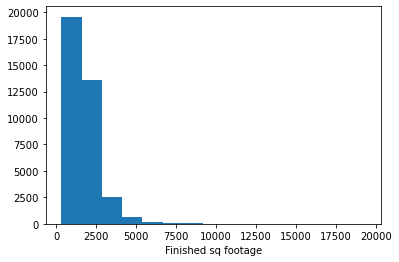

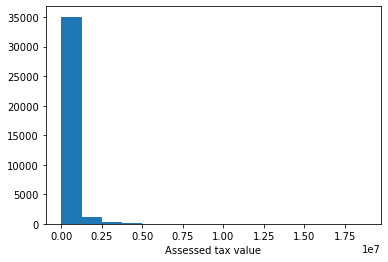

Text(0.5, 0, 'Tax amount')

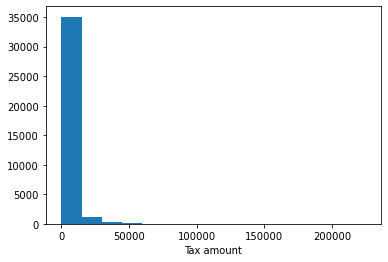

In [18]:
plt.hist(la_county_clean.calc_fin_sqft,bins= 15)
plt.xlabel('Finished sq footage')
plt.show()
plt.hist(la_county_clean.tax_val, bins= 15)
plt.xlabel('Assessed tax value')
plt.show()
plt.hist(la_county_clean.tax_amt, bins= 15)
plt.xlabel('Tax amount')

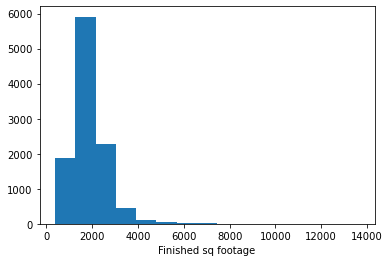

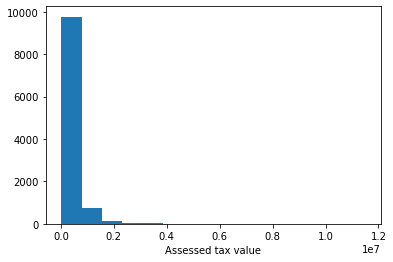

Text(0.5, 0, 'Tax amount')

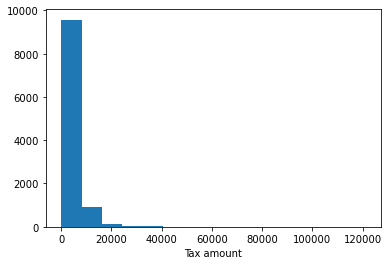

In [19]:
plt.hist(orange_county_clean.calc_fin_sqft,bins= 15)
plt.xlabel('Finished sq footage')
plt.show()
plt.hist(orange_county_clean.tax_val, bins= 15)
plt.xlabel('Assessed tax value')
plt.show()
plt.hist(orange_county_clean.tax_amt, bins= 15)
plt.xlabel('Tax amount')

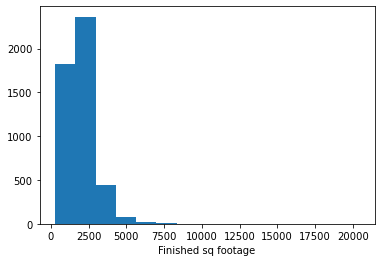

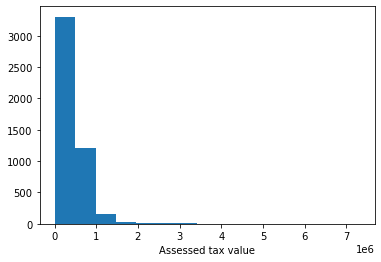

Text(0.5, 0, 'Tax amount')

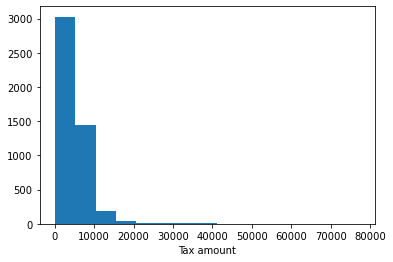

In [20]:
plt.hist(ventura_county_clean.calc_fin_sqft,bins= 15)
plt.xlabel('Finished sq footage')
plt.show()
plt.hist(ventura_county_clean.tax_val, bins= 15)
plt.xlabel('Assessed tax value')
plt.show()
plt.hist(ventura_county_clean.tax_amt, bins= 15)
plt.xlabel('Tax amount')

# Prepping for modeling

### Get splits

In [21]:
#Get train, validate, and test splits for each subset

la_train, la_validate, la_test = ev.get_splits(la_county_clean)
print(la_train.shape, la_validate.shape, la_test.shape)

orange_train, orange_val, orange_test = ev.get_splits(orange_county_clean)
print(orange_train.shape, orange_val.shape, orange_test.shape)

vent_train, vent_val, vent_test = ev.get_splits(ventura_county_clean)
print(vent_train.shape, vent_val.shape, vent_test.shape)

(20538, 13) (8802, 13) (7335, 13)
(5989, 15) (2567, 15) (2139, 15)
(2650, 14) (1136, 14) (947, 14)


In [22]:
# Drop variables that are derived from the target variable

la_train = la_train.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
la_validate = la_validate.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
la_test = la_test.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])

orange_train = orange_train.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
orange_val = orange_val.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
orange_test = orange_test.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])

vent_train = vent_train.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
vent_val = vent_val.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
vent_test = vent_test.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])

### Isolate target variable

In [24]:
from prep import isolate_lm_target

X_la_train, y_la_train, X_la_validate, y_la_validate, X_la_test, y_la_test = isolate_lm_target(la_train, la_validate, la_test, 'tax_val')
X_la_train.info()

X_orange_train, y_orange_train, X_orange_val, y_orange_val, X_orange_test, y_orange_test = isolate_lm_target(orange_train, orange_val, orange_test, 'tax_val')
X_orange_train.info()

X_vent_train, y_vent_train, X_vent_val, y_vent_val, X_vent_test, y_vent_test = isolate_lm_target(vent_train, vent_val, vent_test, 'tax_val')
X_vent_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20538 entries, 20977 to 45951
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           20538 non-null  int64  
 1   baths          20538 non-null  int64  
 2   pool           20538 non-null  uint8  
 3   condition      20538 non-null  int64  
 4   calc_fin_sqft  20538 non-null  float64
 5   lot_sqft       20538 non-null  float64
 6   yr_built       20538 non-null  int64  
 7   county_code    20538 non-null  int64  
 8   log_err        20538 non-null  float64
dtypes: float64(3), int64(5), uint8(1)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5989 entries, 9854 to 20826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           5989 non-null   int64  
 1   baths          5989 non-null   int64  
 2   total_rooms    5989 non-null   int64  
 3   stories 

# Analysis on train split

### LA county train split variable pairs:

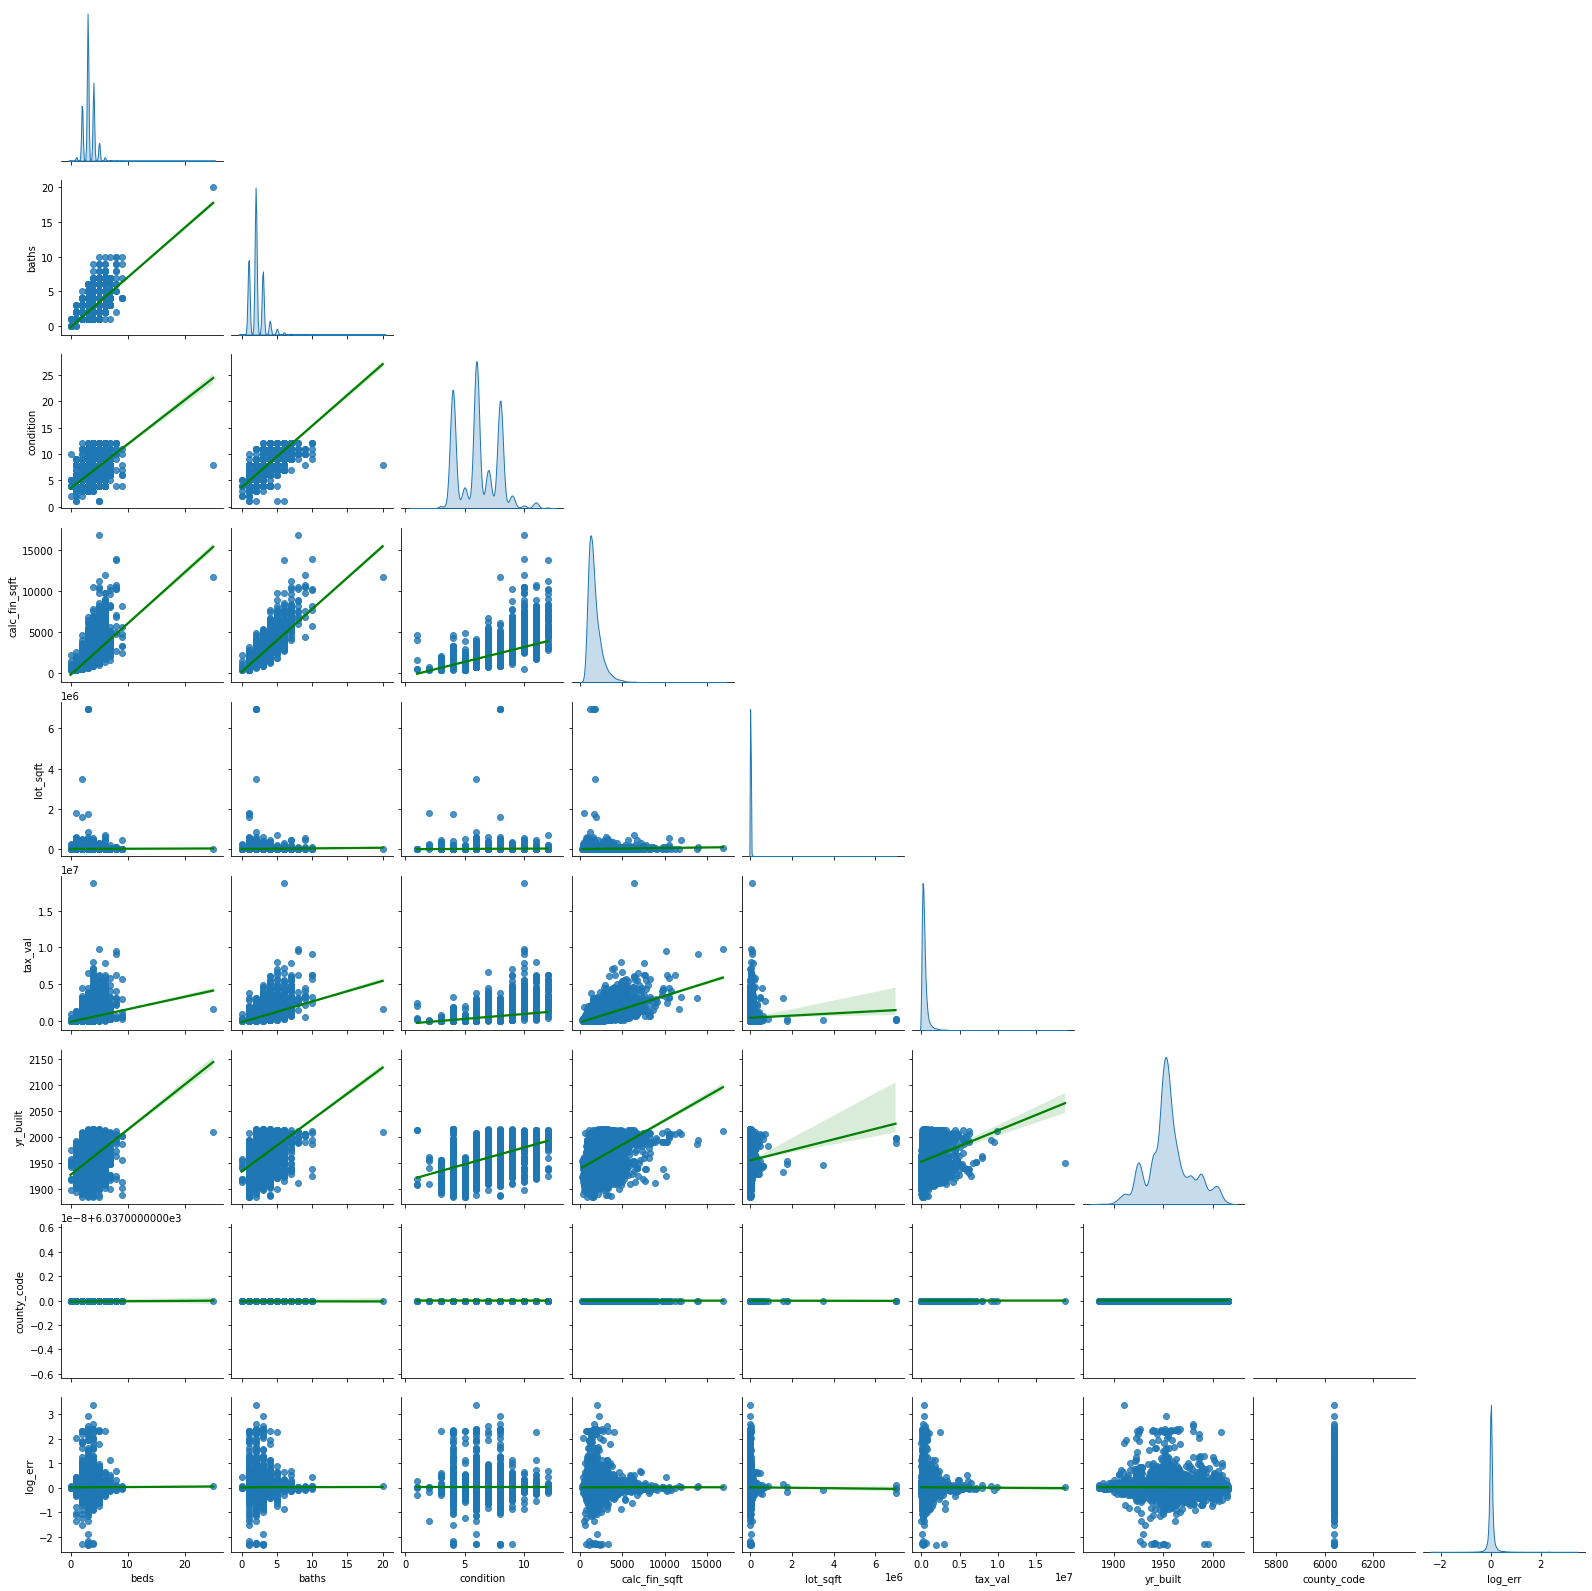

In [25]:
exp.plot_variable_pairs(la_train)

### Orange county train split variable pairs

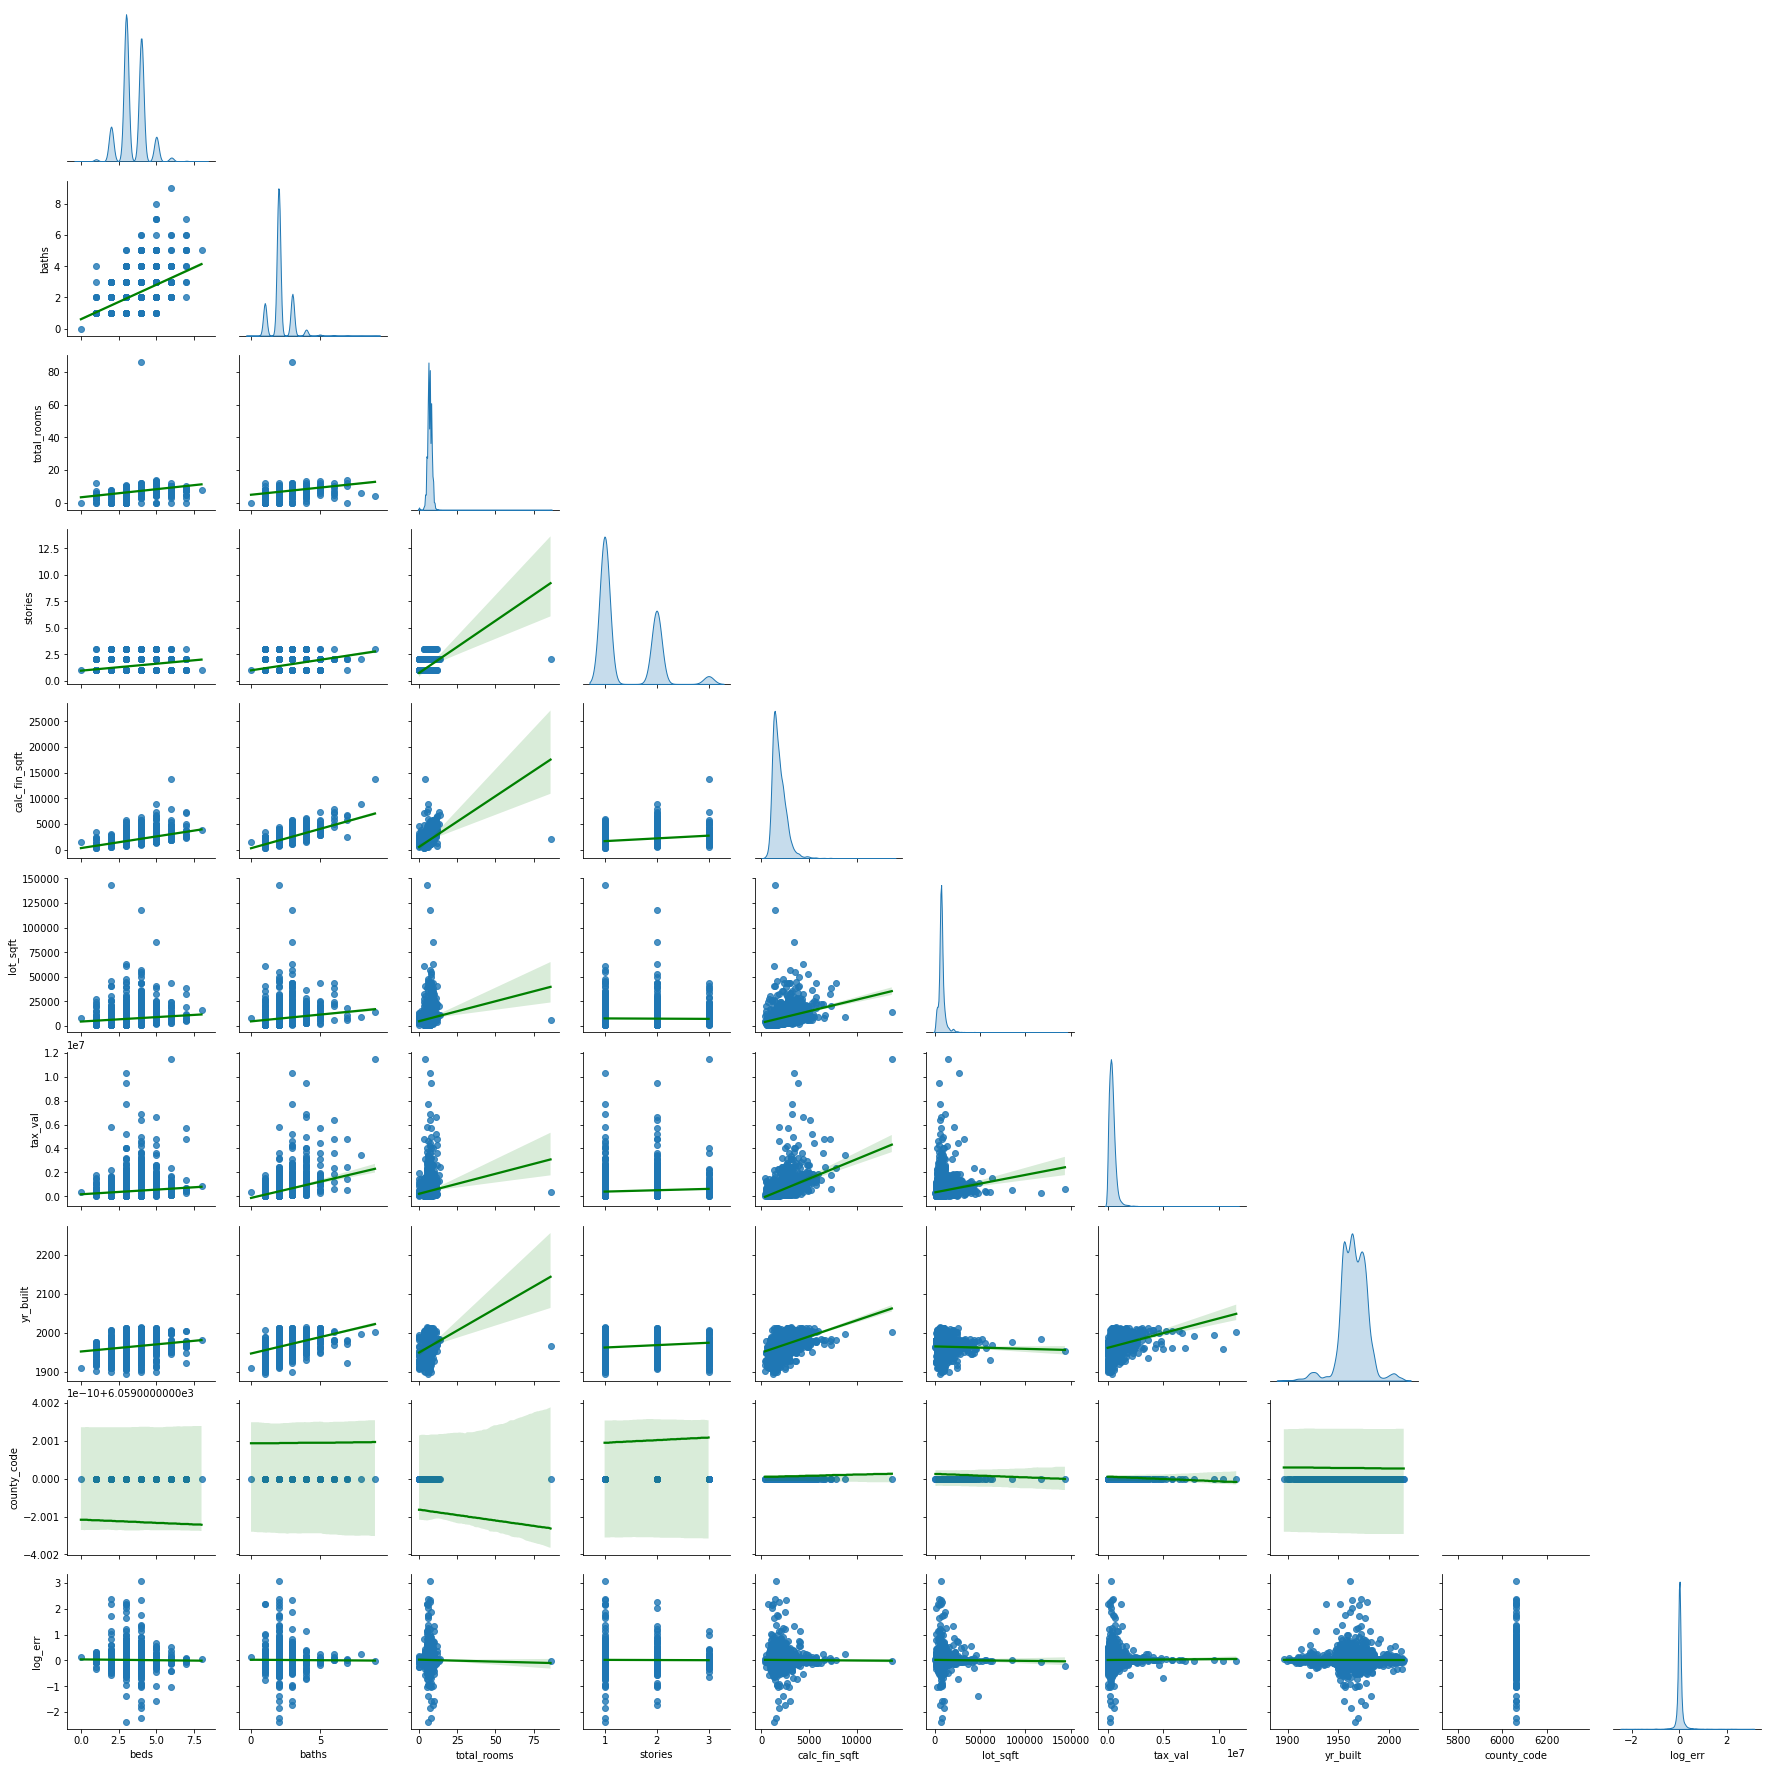

In [26]:
exp.plot_variable_pairs(orange_train)

### Ventura county train split variable pairs

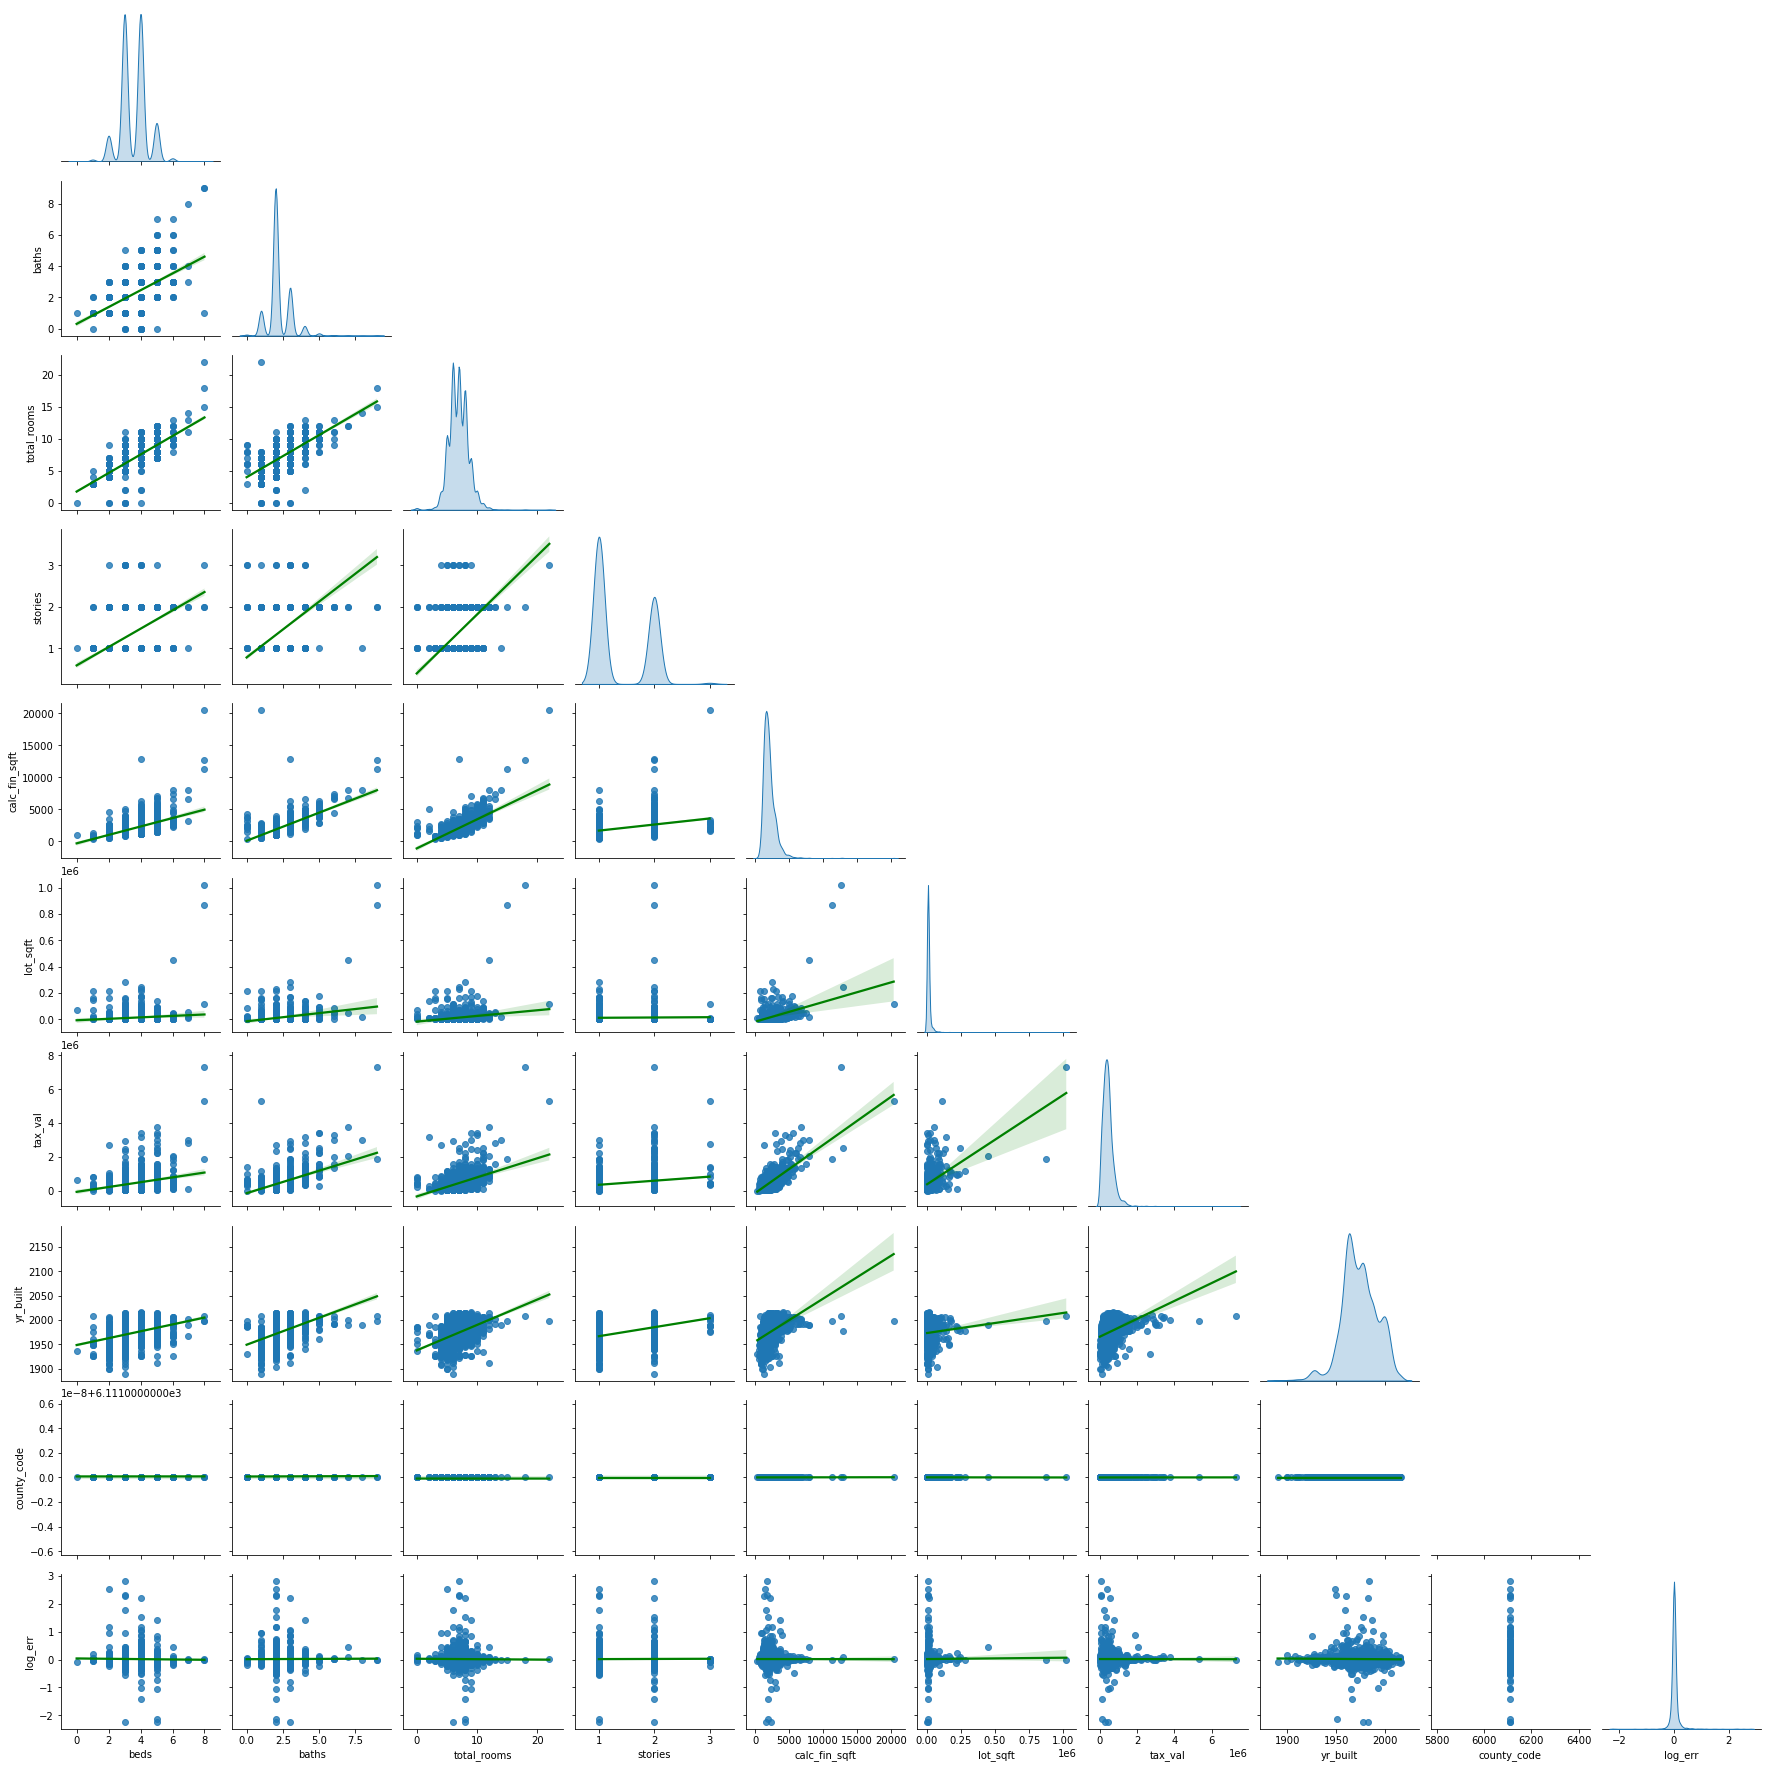

In [27]:
exp.plot_variable_pairs(vent_train)

# Takeaways: Calculated finished square feet appears to be the strongest single driver of tax assessed value. Bedroom and bathroom numbers also appear to have significant impact.

### Scaling

In [28]:
#Scale the LA county train split
cols_to_scale = ['beds', 'baths', 'condition', 'calc_fin_sqft', 'lot_sqft', 'log_err']

X_la_train_scaled = X_la_train.copy()
X_la_validate_scaled = X_la_validate.copy()
X_la_test_scaled = X_la_test.copy()

mmscaler = MinMaxScaler()

mmscaler.fit(X_la_train[cols_to_scale])

X_la_train_scaled[cols_to_scale] = mmscaler.transform(X_la_train[cols_to_scale])
X_la_validate_scaled[cols_to_scale] = mmscaler.transform(X_la_validate[cols_to_scale])
X_la_test_scaled[cols_to_scale] = mmscaler.transform(X_la_test[cols_to_scale])


X_la_train_scaled.head()

,beds,baths,pool,condition,calc_fin_sqft,lot_sqft,yr_built,county_code,log_err
20977,0.24,0.15,1,0.545455,0.210246,0.001045,2002,6037,0.407310
37653,0.12,0.05,0,0.272727,0.043307,0.000739,1959,6037,0.430660
24143,0.08,0.05,1,0.272727,0.042340,0.000691,1939,6037,0.404239
55457,0.08,0.15,0,0.636364,0.089881,0.002624,1964,6037,0.408684
1296,0.12,0.15,1,0.636364,0.091091,0.000953,1952,6037,0.411481


In [29]:
#Scale the Orange county split
cols_to_scale = ['beds', 'baths', 'total_rooms', 'stories', 'calc_fin_sqft', 'lot_sqft', 'log_err']

X_orange_train_scaled = X_orange_train.copy()
X_orange_validate_scaled = X_orange_val.copy()
X_orange_test_scaled = X_orange_test.copy()

mmscaler = MinMaxScaler()

mmscaler.fit(X_orange_train[cols_to_scale])

X_orange_train_scaled[cols_to_scale] = mmscaler.transform(X_orange_train[cols_to_scale])
X_orange_validate_scaled[cols_to_scale] = mmscaler.transform(X_orange_val[cols_to_scale])
X_orange_test_scaled[cols_to_scale] = mmscaler.transform(X_orange_test[cols_to_scale])


X_orange_train_scaled.head()

,beds,baths,total_rooms,stories,fireplace,pools,calc_fin_sqft,lot_sqft,yr_built,county_code,log_err
9854,0.500,0.222222,0.081395,0.0,0,0,0.074878,0.036115,1971,6059,0.604264
40526,0.375,0.222222,0.081395,0.0,0,0,0.100113,0.050695,1956,6059,0.435038
19652,0.500,0.333333,0.081395,0.0,0,0,0.178757,0.175339,1961,6059,0.456245
30605,0.500,0.222222,0.081395,0.0,0,0,0.068625,0.048224,1955,6059,0.433675
8874,0.500,0.222222,0.093023,0.0,0,0,0.138832,0.057595,1966,6059,0.449494


In [30]:
#Scale the Ventura county train split
cols_to_scale = ['beds', 'baths', 'total_rooms', 'stories', 'calc_fin_sqft', 'lot_sqft', 'log_err']

X_vent_train_scaled = X_vent_train.copy()
X_vent_validate_scaled = X_vent_val.copy()
X_vent_test_scaled = X_vent_test.copy()

mmscaler = MinMaxScaler()

mmscaler.fit(X_vent_train[cols_to_scale])

X_vent_train_scaled[cols_to_scale] = mmscaler.transform(X_vent_train[cols_to_scale])
X_vent_validate_scaled[cols_to_scale] = mmscaler.transform(X_vent_val[cols_to_scale])
X_vent_test_scaled[cols_to_scale] = mmscaler.transform(X_vent_test[cols_to_scale])

X_vent_train_scaled.head()

,beds,baths,total_rooms,stories,pool,calc_fin_sqft,lot_sqft,yr_built,county_code,log_err
21872,0.375,0.111111,0.227273,0.0,0,0.038589,0.004170,1951,6111,0.433667
227,0.375,0.222222,0.227273,0.5,0,0.051932,0.002277,1994,6111,0.441348
11131,0.500,0.222222,0.318182,0.0,0,0.069739,0.004685,1977,6111,0.447020
21828,0.625,0.222222,0.363636,0.0,0,0.083230,0.004464,1965,6111,0.501789
11147,0.375,0.222222,0.318182,0.0,0,0.069987,0.004669,1959,6111,0.459342


# Modeling

### LA county models:

In [31]:
X_latr_ols = LinearRegression().fit(X_la_train_scaled, y_la_train.tax_val)

yhat_scaled = X_latr_ols.predict(X_la_train_scaled)

y_la_train['yhat_scaled'] = yhat_scaled

y_la_train.head()
latr_mse = mean_squared_error(y_la_train.tax_val, y_la_train.yhat_scaled)

latr_mse ** 0.5

393178.3225140324

In [32]:
f_feature = prep.select_kbest(X_la_train_scaled, y_la_train.tax_val, 4)

f_feature

['beds', 'baths', 'condition', 'calc_fin_sqft']

Kbest features model

In [34]:
la_kbest_ols = LinearRegression().fit(X_la_train_scaled[f_feature], y_la_train.tax_val)

y_la_train['baseline'] = y_la_train.tax_val.mean()
y_la_train['yhat_kbest'] = la_kbest_ols.predict(X_la_train_scaled[f_feature])

y_la_train.head()

,tax_val,yhat_scaled,yhat_kbest,baseline
20977,690966.0,842607.827078,937571.530014,423457.341611
37653,401023.0,31115.399687,98779.935735,423457.341611
24143,259740.0,251622.459034,200158.787061,423457.341611
55457,476190.0,602037.677380,615113.400042,423457.341611
1296,586416.0,610719.234528,515252.388662,423457.341611


In [35]:
kbest_rmse = mean_squared_error(y_la_train.tax_val, y_la_train.yhat_kbest) ** 0.5

kbest_rmse

398913.2093893992

RFE model

In [36]:
rfe_feature, rfe_ranked = prep.rfe(X_la_train_scaled, y_la_train.tax_val, 4)

rfe_ranked

,Var,Rank
0,beds,1
1,baths,1
2,pool,3
3,condition,4
4,calc_fin_sqft,1
5,lot_sqft,1
6,yr_built,5
7,county_code,6
8,log_err,2


In [37]:
la_rfe_ols = LinearRegression().fit(X_la_train_scaled[rfe_feature], y_la_train.tax_val)

y_la_train['yhat_rfe'] = la_rfe_ols.predict(X_la_train_scaled[rfe_feature])

y_la_train.head()

,tax_val,yhat_scaled,yhat_kbest,baseline,yhat_rfe
20977,690966.0,842607.827078,937571.530014,423457.341611,939764.317709
37653,401023.0,31115.399687,98779.935735,423457.341611,101274.800523
24143,259740.0,251622.459034,200158.787061,423457.341611,202881.495428
55457,476190.0,602037.677380,615113.400042,423457.341611,612073.369818
1296,586416.0,610719.234528,515252.388662,423457.341611,512167.924240


In [38]:
la_rfe_rmse = mean_squared_error(y_la_train.tax_val, y_la_train.yhat_rfe) ** 0.5

la_rfe_rmse

398924.840912903

In [40]:
la_bl_rmse = mean_squared_error(y_la_train.tax_val, y_la_train.baseline) ** 0.5

la_bl_rmse

526336.6394868336

# LA county findings: Models outperformed the baseline by about $130k. Finished square footage and a combination of bedroom and bathroom counts were the most selected features

### Orange county models

In [42]:
X_orange_tr_ols = LinearRegression().fit(X_orange_train_scaled, y_orange_train.tax_val)

y_orange_train['baseline'] = y_orange_train.tax_val.mean()
y_orange_train['yhat_scaled'] = X_orange_tr_ols.predict(X_orange_train_scaled)

y_orange_train.head()

,tax_val,yhat_scaled,baseline
9854,710000.0,251475.981632,429082.602939
40526,254683.0,413904.290740,429082.602939
19652,693515.0,748904.242173,429082.602939
30605,294719.0,158279.985401,429082.602939
8874,326970.0,506947.609827,429082.602939


In [43]:
orange_yhat_rmse = mean_squared_error(y_orange_train.tax_val, y_orange_train.yhat_scaled) ** 0.5

orange_yhat_rmse

410114.61770677316

Kbest model

In [44]:
f_feature = prep.select_kbest(X_orange_train_scaled, y_orange_train.tax_val, 5)

f_feature

['beds', 'baths', 'calc_fin_sqft', 'lot_sqft', 'yr_built']

In [45]:
orange_kbest_ols = LinearRegression().fit(X_orange_train_scaled[f_feature], y_orange_train.tax_val)

y_orange_train['yhat_kbest'] = orange_kbest_ols.predict(X_orange_train_scaled[f_feature])

y_orange_train.head()

,tax_val,yhat_scaled,baseline,yhat_kbest
9854,710000.0,251475.981632,429082.602939,206698.833055
40526,254683.0,413904.290740,429082.602939,409253.245950
19652,693515.0,748904.242173,429082.602939,705437.330961
30605,294719.0,158279.985401,429082.602939,154673.428683
8874,326970.0,506947.609827,429082.602939,478026.561031


In [46]:
orange_kbest_rmse = mean_squared_error(y_orange_train.tax_val, y_orange_train.yhat_kbest) ** 0.5

orange_kbest_rmse

413657.0517235144

RFE model

In [47]:
rfe_feature, rfe_ranked = prep.rfe(X_orange_train_scaled, y_orange_train.tax_val, 5)

rfe_ranked

,Var,Rank
0,beds,1
1,baths,1
2,total_rooms,1
3,stories,3
4,fireplace,5
5,pools,4
6,calc_fin_sqft,1
7,lot_sqft,1
8,yr_built,6
9,county_code,7


In [48]:
orange_rfe_ols = LinearRegression().fit(X_orange_train_scaled[rfe_feature], y_orange_train.tax_val)

y_orange_train['yhat_rfe'] = orange_rfe_ols.predict(X_orange_train_scaled[rfe_feature])

y_orange_train.head()

,tax_val,yhat_scaled,baseline,yhat_kbest,yhat_rfe
9854,710000.0,251475.981632,429082.602939,206698.833055,188433.983178
40526,254683.0,413904.290740,429082.602939,409253.245950,401990.865348
19652,693515.0,748904.242173,429082.602939,705437.330961,727485.047969
30605,294719.0,158279.985401,429082.602939,154673.428683,153829.678232
8874,326970.0,506947.609827,429082.602939,478026.561031,463079.351313


In [49]:
orange_rfe_rmse = mean_squared_error(y_orange_train.tax_val, y_orange_train.yhat_rfe) ** 0.5

orange_rfe_rmse

412110.4189693739

In [50]:
orange_bl_rmse = mean_squared_error(y_orange_train.tax_val, y_orange_train.baseline) ** 0.5

orange_bl_rmse

487540.09539687866

# Orange county findings: Models performed over $70k better than baseline. Again, finished square footage and room count were preferred features.

### Ventura county models

In [51]:
X_vent_ols = LinearRegression().fit(X_vent_train_scaled, y_vent_train.tax_val)

y_vent_train['baseline'] = y_vent_train.tax_val.mean()
y_vent_train['yhat_scaled'] = X_vent_ols.predict(X_vent_train_scaled)

y_vent_train.head()

,tax_val,baseline,yhat_scaled
21872,334000.0,441307.662642,136422.123346
227,273864.0,441307.662642,309629.831655
11131,250840.0,441307.662642,310557.716956
21828,385379.0,441307.662642,286232.903798
11147,58676.0,441307.662642,334258.212811


Kbest model

In [52]:
f_feature = prep.select_kbest(X_vent_train_scaled, y_vent_train.tax_val, 5)

f_feature

['baths', 'total_rooms', 'calc_fin_sqft', 'lot_sqft', 'yr_built']

In [53]:
vent_kbest_ols = LinearRegression().fit(X_vent_train_scaled[f_feature], y_vent_train.tax_val)

y_vent_train['yhat_kbest'] = vent_kbest_ols.predict(X_vent_train_scaled[f_feature])

y_vent_train.head()

,tax_val,baseline,yhat_scaled,yhat_kbest
21872,334000.0,441307.662642,136422.123346,156307.296649
227,273864.0,441307.662642,309629.831655,334899.509771
11131,250840.0,441307.662642,310557.716956,334226.040797
21828,385379.0,441307.662642,286232.903798,350068.579834
11147,58676.0,441307.662642,334258.212811,307065.978108


In [54]:
vent_kbest_rmse = mean_squared_error(y_vent_train.tax_val, y_vent_train.yhat_kbest) ** 0.5

vent_kbest_rmse

245272.2695476488

RFE model

In [55]:
rfe_feature, rfe_ranked = prep.rfe(X_vent_train_scaled, y_vent_train.tax_val, 5)

rfe_ranked

,Var,Rank
0,beds,1
1,baths,1
2,total_rooms,1
3,stories,4
4,pool,3
5,calc_fin_sqft,1
6,lot_sqft,1
7,yr_built,5
8,county_code,6
9,log_err,2


In [56]:
vent_rfe_ols = LinearRegression().fit(X_vent_train_scaled[rfe_feature], y_vent_train.tax_val)

y_vent_train['yhat_rfe'] = vent_rfe_ols.predict(X_vent_train_scaled[rfe_feature])

y_vent_train.head()

,tax_val,baseline,yhat_scaled,yhat_kbest,yhat_rfe
21872,334000.0,441307.662642,136422.123346,156307.296649,151904.706468
227,273864.0,441307.662642,309629.831655,334899.509771,283692.205315
11131,250840.0,441307.662642,310557.716956,334226.040797,300935.473378
21828,385379.0,441307.662642,286232.903798,350068.579834,302890.273903
11147,58676.0,441307.662642,334258.212811,307065.978108,360323.361381


In [57]:
vent_rfe_rmse = mean_squared_error(y_vent_train.tax_val, y_vent_train.yhat_rfe) ** 0.5

vent_rfe_rmse

244367.14447117012

In [58]:
vent_bl_rmse = mean_squared_error(y_vent_train.tax_val, y_vent_train.baseline) ** 0.5

vent_bl_rmse

379063.9859674863

### Ventura county findings: Models outperformed the baseline by ~$135k. Finished sq footage and room counts again are preferred features.

# Conclusions: Primary features to include in a linear regression model for this data were finished square footage and a combination of the counts of bedrooms and bathrooms. Finding a balance of the number of features to include is key.